In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

# Assignment 3 (Part 2)

We can construct a lattice of two different states:

    1. Uniform spin alignment.
    2. Random spin alignment.
Based on these two systems, we can then use MCMC to plot the magnetization in the system over time, rather than working with tons of calculations. 

In [10]:
N = 20         # Lattice size (NxN grid)
J = 1          # Interaction strength (ferromagnetic)
k_B = 1         # Boltzmann constant
STEPS = 500_000  # Total Monte Carlo steps for Problem A
BURNIN = 50_000  # Burn-in period (initial steps discarded)

In [11]:
def compute_energy(lattice):
    #Compute total energy of the Ising lattice.
    energy = 0
    N = lattice.shape[0]
    for i in range(N):
        for j in range(N):
            for k, l in [(-1, 0), (1, 0), (0, 1), (0, -1)]:  # Nearest neighbors
                i_neigh = (i + k) % N  # Periodic BC
                j_neigh = (j + l) % N
                energy += -J * 1/2 *lattice[i, j] * lattice[i_neigh, j_neigh] - B * lattice[i, j]
    return energy  # Avoid double-counting

# Energy computation

Recall that the energy stored in our lattice is given by:
$$E(\sigma) = -J \sum_{\langle ij \rangle} \sigma_i \sigma_j - B\sum_{i \in \Lambda} \sigma_i $$

This formula is further simplified by the fact that $J$ is equal to 1.

# Metropolis Hastings algorithm

Since we have a really large sample, we can use the Metropolis Hastings algorithm to either add or disregard new samples within the distribution.

In [12]:
def metropolis(lattice, T, steps):
    # Returns magnetization values over time.
    N = lattice.shape[0]
    magnetization = []  # Track magnetization over time
    num_accept = 0  # Count accepted flips

    for _ in tqdm.tqdm(range(steps)):
        i, j = np.random.randint(N), np.random.randint(N)  # Pick random spin
        delta_E = 0

        # Compute energy change ΔE if flipping spin (i, j)
        for k, l in [(-1, 0), (1, 0), (0, 1), (0, -1)]:  # Nearest neighbors
            i_neigh = (i + k) % N
            j_neigh = (j + l) % N
            delta_E += -J * -2 * lattice[i, j] * lattice[i_neigh, j_neigh] - B * lattice[i, j]

        # Metropolis acceptance rule
        if delta_E <= 0 or np.random.random() < np.exp(-delta_E / (k_B * T)):
            lattice[i, j] *= -1  # Flip spin
            num_accept += 1

        # Track magnetization per spin
        magnetization.append(np.mean(lattice))

    acceptance_rate = num_accept / steps
    print(f"Acceptance rate at T={T}: {acceptance_rate:.4f}")
    return magnetization


# Part A
At $T = 2$ we can plot the magnetization of two different lattice configurations with a designated burn-in period. Since this is a random initial distribution, the end result can either be all spins up or all spins down. This and the burn-in period will be shown in the following graph from this code

100%|██████████| 500000/500000 [00:13<00:00, 38340.71it/s]


Acceptance rate at T=2: 0.0778


100%|██████████| 500000/500000 [00:13<00:00, 37154.93it/s]


Acceptance rate at T=2: 0.0854


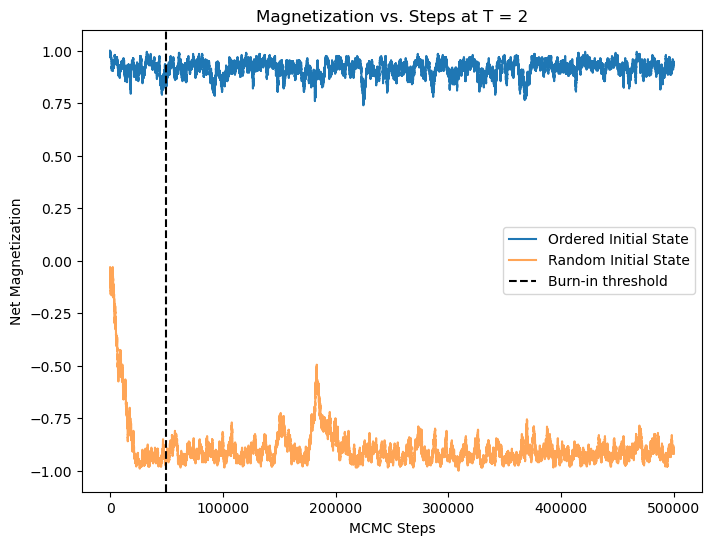

Mean magnetization (Ordered) = 0.9154
Mean magnetization (Random)  = -0.9056


In [13]:
# Run for both initial configurations
def initialize_lattice(N, mode="ordered"):
    # Initialize a NxN Ising lattice.
    # mode="ordered": All spins +1
    # mode="random": Spins randomly +1 or -1
    if mode == "ordered":
        return np.ones((N, N))
    elif mode == "random":
        return np.random.choice([-1, 1], size=(N, N))

T_A = 2
lattice_ordered = initialize_lattice(N, mode="ordered")
lattice_random = initialize_lattice(N, mode="random")

m_ordered = metropolis(lattice_ordered, T_A, STEPS)
m_random = metropolis(lattice_random, T_A, STEPS)

# Plot magnetization vs. steps
plt.figure(figsize=(8, 6))
plt.plot(range(STEPS), m_ordered, label="Ordered Initial State")
plt.plot(range(STEPS), m_random, label="Random Initial State", alpha=0.7)
plt.axvline(BURNIN, color="black", linestyle="--", label="Burn-in threshold")
plt.xlabel("MCMC Steps")
plt.ylabel("Net Magnetization")
plt.title(f"Magnetization vs. Steps at T = {T_A}")
plt.legend()
plt.show()

# Compute mean magnetization after burn-in
m_mean_ordered = np.mean(m_ordered[BURNIN:])
m_mean_random = np.mean(m_random[BURNIN:])
print(f"Mean magnetization (Ordered) = {m_mean_ordered:.4f}")
print(f"Mean magnetization (Random)  = {m_mean_random:.4f}")

Notice that we could in theory get away with a lower burn in, roughly at around 35000 steps, for the random initial state.

# Multiple values of T

We can instead iterate over different temperatures to see how this affects the end result of the mean magnetization. This is going to take a while to run for each lattice.

In [14]:
temps = np.arange(1, 4.2, 0.2)  # T = 1 to 4 in steps of 0.2
m_means = []
m_stds = []

for T in temps:
    lattice = initialize_lattice(N, mode="random")  # Random spins lattice
    m_vals = metropolis(lattice, T, STEPS)
    m_means.append(np.mean(m_vals[BURNIN:]))  # Mean magnetization after burn-in
    m_stds.append(np.std(m_vals[BURNIN:]))    # Standard deviation

# Magnetization vs. Temperature plot
Tc = 2 / np.log(1 + np.sqrt(2))  # Theoretical critical temperature (~2.269)
plt.figure(figsize=(8, 6))
plt.errorbar(temps, m_means, yerr=m_stds, fmt="o-", capsize=5, label="Simulation Data")
plt.axvline(Tc, color="r", linestyle="--", label=r"Theoretical $T_c$")
plt.xlabel("Temperature (T)")
plt.ylabel("Mean Magnetization")
plt.title("Magnetization vs. Temperature in 2D Ising Model")
plt.legend()
plt.show()

 67%|██████▋   | 336768/500000 [00:09<00:04, 35826.15it/s]


KeyboardInterrupt: 

Given our value for the critical temperature, we can find the temperature in our data which is the closest to this value and analyze its behavior. If the system reaches this critical temperature, we should expect the system to switch back and forth between ordered and disordered states. If we go lower, the system will settle back into an ordered state.

In [ ]:
print(f"Theoretical Critical Temperature: {Tc:.3f}")
Tc_index = np.argmin(np.abs(temps - Tc))  # Find closest T in the simulation data
print(f"Simulated Magnetization Near Tc ({temps[Tc_index]}): {m_means[Tc_index]:.4f}")
print(f"Standard Deviation at Tc: {m_stds[Tc_index]:.4f}")